In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scipy as sp
import muon as mu
from muon import atac as ac
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcdefaults()

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

## Read multimodal datasets

In [2]:
adata_celldreamer = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/pbmc10k_multimodal/generated_cells_0_atac.h5ad")
adata_peakvi = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/peakvi/pbmc/generated/pbmc10k_multimodal_1.h5ad")
adata_multivi = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/multivi/pbmc/generated/atac/pbmc10k_multimodal_0.h5ad")
adata_real = mu.read("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/pbmc/pbmc10k_multiome_test.h5mu")

In [3]:
adata_real_atac = adata_real["atac"]
adata_real_atac.obs = adata_real["rna"].obs

In [4]:
adata_peakvi.obs = adata_real_atac.obs.copy()
adata_multivi.obs = adata_real_atac.obs.copy()

In [5]:
adata_celldreamer.var = adata_real_atac.var.copy()
adata_peakvi.var = adata_real_atac.var.copy()
adata_multivi.var = adata_real_atac.var.copy()

In [6]:
adata_multivi.X = np.where(adata_multivi.X.A>0.5, 1, 0)
adata_peakvi.X = np.where(adata_peakvi.X.A>0.5, 1, 0)

In [7]:
marker_peaks = [
    'chr14:99255246-99275454', 'chr10:33135632-33141841',                              # T/NK
    'chr1:1210271-1220028',                                                            # memory T/NK
    'chr2:86783559-86792275',                                                          # CD8+ T/NK
    'chr12:10552886-10555668',                                                         # naïve CD8+ T
    'chr11:114072228-114076352',                                                       # MAIT/NK
    # 'chr5:150385442-150415310',                                                        # B and mono (CD74)
    'chr22:41931503-41942227', 'chr22:41917087-41929835', 'chr6:167111604-167115345',  # B
    'chr9:107480158-107492721', 'chr5:1476663-1483241',                                # mono
    'chr10:75399596-75404660', 'chr1:220876295-220883526',                             # mDC
    'chr17:81425658-81431769'                              # pDC
]

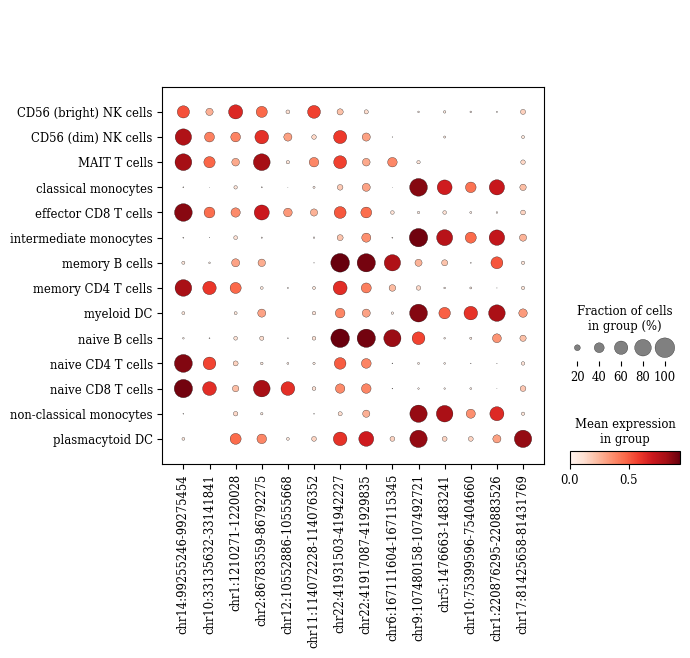

In [12]:
ac.pl.dotplot(adata_real, marker_peaks, groupby='cell_type', save="dotplot_real.svg")

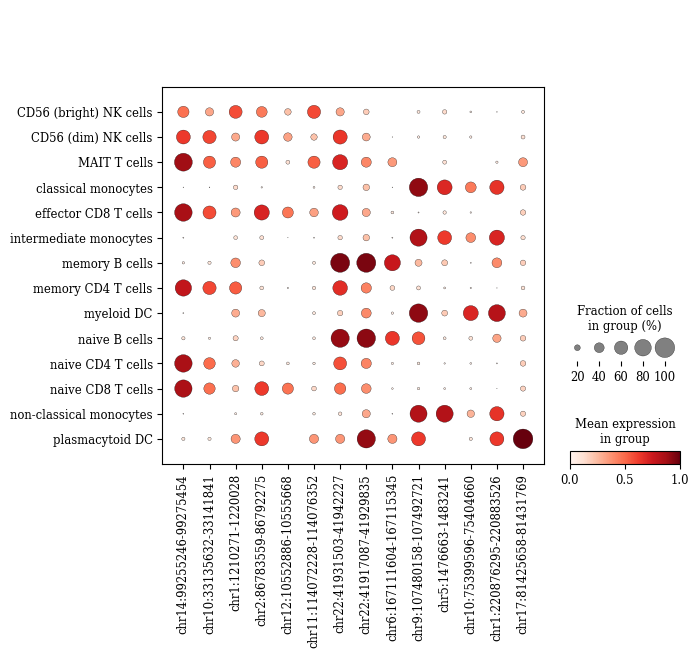

In [13]:
ac.pl.dotplot(adata_celldreamer, marker_peaks, groupby='cell_type', save="dotplot_cellflow.svg")

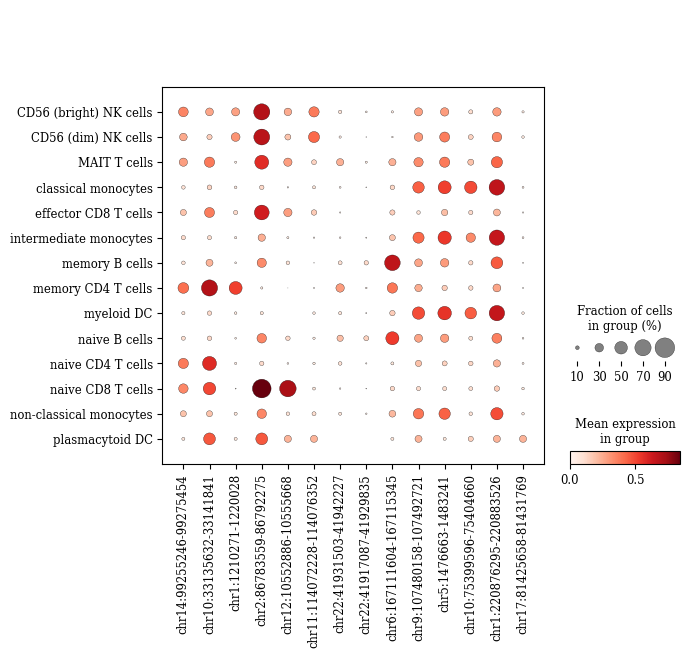

In [10]:
ac.pl.dotplot(adata_peakvi, marker_peaks, groupby='cell_type')

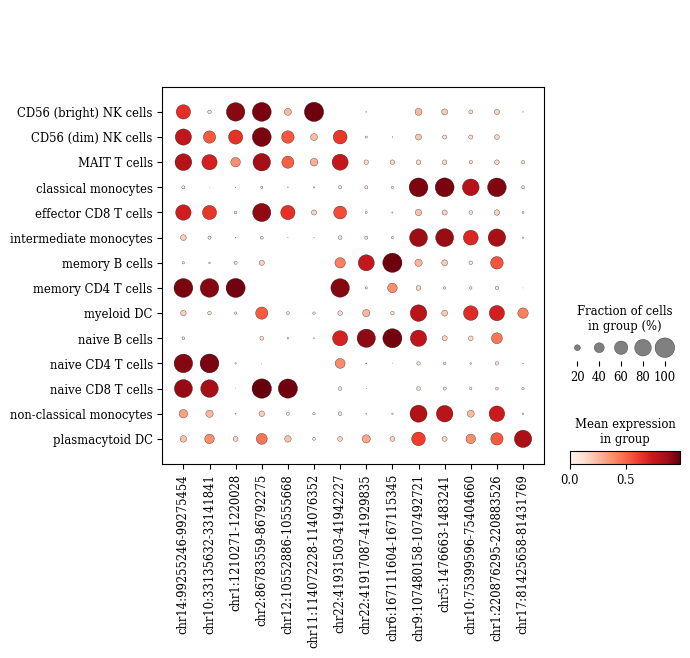

In [14]:
ac.pl.dotplot(adata_multivi, marker_peaks, groupby='cell_type', save="dotplot_multivi.svg")

## Get fraction of expressed peaks per cell type 

In [14]:
adata_peakvi = adata_peakvi[:, marker_peaks]
adata_real_atac = adata_real_atac[:, marker_peaks]
adata_multivi = adata_multivi[:, marker_peaks]
adata_celldreamer = adata_celldreamer[:, marker_peaks]

In [15]:
cell_types = adata_real_atac.obs['cell_type'].unique()
marker_peaks = adata_real_atac.var_names

In [16]:
def ct_acc_matrix(adata):
    # Initialize the matrix to store fractions
    fraction_matrix = pd.DataFrame(index=cell_types, columns=marker_peaks)
    
    # Iterate over each cell type and marker peak
    for cell_type in cell_types:
        # Subset the data for the current cell type
        cell_type_data = adata[adata.obs['cell_type'] == cell_type]
        
        # Calculate the fraction of cells with accessible peaks for each marker peak
        for peak in marker_peaks:
            accessible_cells = cell_type_data[:, peak].X.toarray().flatten()  # Convert to a flat array
            fraction_accessible = accessible_cells.mean()  # Calculate the fraction of accessible cells
            fraction_matrix.loc[cell_type, peak] = fraction_accessible
    
    # Convert the matrix to float type for consistency
    fraction_matrix = fraction_matrix.astype(float)
    return fraction_matrix

In [17]:
ct_acc_mat_peakvi = ct_acc_matrix(adata_peakvi)
ct_acc_mat_multivi = ct_acc_matrix(adata_multivi)
ct_acc_mat_celldreamer = ct_acc_matrix(adata_celldreamer)
ct_acc_mat_real = ct_acc_matrix(adata_real_atac)


## Compute correlations

In [18]:
corr_peakvi = ct_acc_mat_peakvi.corrwith(ct_acc_mat_real, axis = 1) 

In [19]:
corr_celldreamer = ct_acc_mat_celldreamer.corrwith(ct_acc_mat_real, axis = 1) 

In [20]:
corr_multivi = ct_acc_mat_multivi.corrwith(ct_acc_mat_real, axis = 1) 

In [21]:
to_plot = {"method": ["cellFlow" for _ in range(len(corr_celldreamer))] + ["multiVI" for _ in range(len(corr_celldreamer))] + ["peakVI" for _ in range(len(corr_celldreamer))],
          "corr": list(corr_celldreamer) + list(corr_multivi) + list(corr_peakvi),
          "cell_type": list(corr_celldreamer.index) + list(corr_multivi.index) + list(corr_peakvi.index)}

for i, ct in enumerate(to_plot["cell_type"]):
    to_plot["cell_type"][i] = to_plot["cell_type"][i][0].upper() + to_plot["cell_type"][i][1:]

In [22]:
to_plot = {"method": ["cellFlow" for _ in range(len(corr_celldreamer))] + ["MultiVI" for _ in range(len(corr_celldreamer))] ,
          "corr": list(corr_celldreamer) + list(corr_multivi) ,
          "cell_type": list(corr_celldreamer.index) + list(corr_multivi.index) }

for i, ct in enumerate(to_plot["cell_type"]):
    to_plot["cell_type"][i] = to_plot["cell_type"][i][0].upper() + to_plot["cell_type"][i][1:]

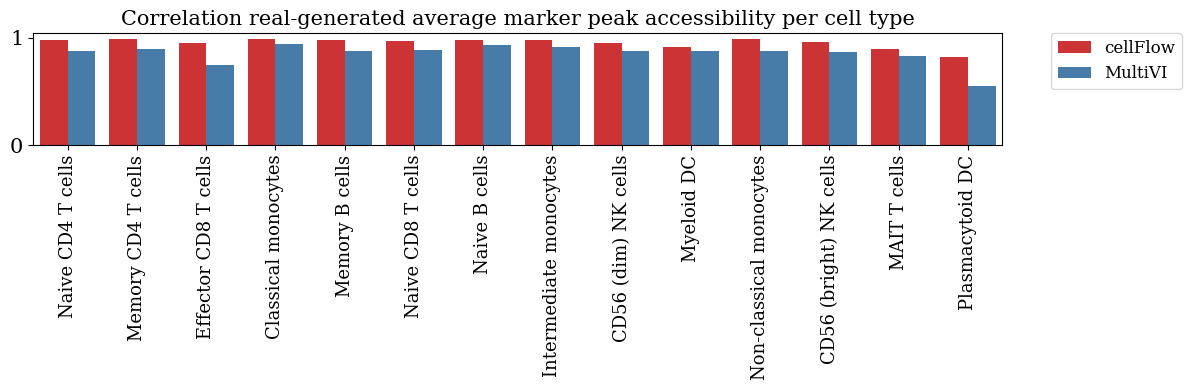

In [26]:
import seaborn as sns


fig = plt.figure(figsize=(12,4))
sns.barplot(data=to_plot, x="cell_type", hue="method", y="corr", palette="Set1")
plt.xticks(rotation=90, fontsize=13)
plt.yticks([0,1], fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, borderaxespad=0.)
plt.title("Correlation real-generated average marker peak accessibility per cell type", fontsize=15)
plt.tight_layout()
plt.savefig("/home/icb/alessandro.palma/environment/celldreamer/figs/multimodal/atac_corr.svg", format="svg")
plt.show()